# Estimate Climate Driver Influence on Rainfall <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible the `NCI` environment
* **Products used:** [BOM Rainfall Grids](https://explorer.dea.ga.gov.au/bom_rainfall_grids)

## Background

There are three main climate drivers for the Australian continent: the El Niño-Southern Oscillation (ENSO), the Southern Annular Mode (SAM), and the Indian Ocean Dipole (IOD). ENSO is the climate driver associated with Pacific Ocean El Niño and La Niña events (ENSO phases). These events together affect climate and rainfall patterns in Australia. Different regions of Australia are affected quite differently. We are interested in the behaviour of waterbodies throughout the continent, but we need a rainfall baseline to compare these to.

## Description

This notebook estimates the influence of climate drivers on Australian rainfall in much the same way as [ENSOInfluence.ipynb](../Scientific_workflows/DEAWaterbodies/DEAWaterbodiesToolkit/ENSOInfluence.ipynb).

***

## Getting started

Run the first cell, which loads all modules needed for this notebook.

### Load modules

In [1]:
import warnings

%matplotlib inline
import datacube
import numpy as np
import pandas as pd
import xarray
from matplotlib import pyplot as plt
from odc.ui import with_ui_cbk
from tqdm.notebook import tqdm
import statsmodels.tsa.seasonal
import matplotlib.patches
import mpl_toolkits.basemap

import sys

sys.path.insert(1, "../Scripts")
from dea_plotting import display_map

### Configuration

Choose a subset of Australia to examine:

In [2]:
southwest = (-44.367634, 112.417252)
northeast = (-10.116211, 154.898971)

# Convert the coordinates into latitude and longitude ranges.
ylim, xlim = zip(southwest, northeast)

In [3]:
# Show a map of the the selected region.
display_map(xlim, ylim)

### Connect to the datacube

In [4]:
dc = datacube.Datacube(app="estimate-climate-driver-influence-on-rainfall")

### Load gridded rainfall

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)
    # Load all data between 1988 and the time of writing,
    # and downsample to 0.5 degree resolution.
    rainfall = dc.load(
        "bom_rainfall_grids",
        time=("1988-01", "2020-10-19"),
        latitude=ylim,
        longitude=xlim,
        progress_cbk=with_ui_cbk(),
        resolution=(0.5, 0.5),
        resampling="average",
    )

### Load Climate Indices

The Southern Oscillation Index (SOI) tracks ENSO based on pressure differences between Tahiti and Darwin. SAM is tracked by the Antarctic Oscillation Index (AAO), a measure of pressure difference across the Antarctic. Finally, the Dipole Mode Index (DMI) tracks the IOD.

The United States National Oceanic and Atmospheric Administration (NOAA) has an easily-accessed record of the SOI, AAO, and DMI, which we load here.

In [6]:
%%bash
# Download the data.
wget https://stateoftheocean.osmc.noaa.gov/atm/data/soi.nc
wget https://stateoftheocean.osmc.noaa.gov/sur/data/dmi.nc
wget https://stateoftheocean.osmc.noaa.gov/atm/data/sam.nc

--2020-10-22 14:45:58--  https://stateoftheocean.osmc.noaa.gov/atm/data/soi.nc
Resolving stateoftheocean.osmc.noaa.gov... 161.55.85.40
Connecting to stateoftheocean.osmc.noaa.gov|161.55.85.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28604 (28K) [application/x-netcdf]
Saving to: `soi.nc.4'

     0K .......... .......... .......                         100%  190K=0.1s

2020-10-22 14:46:02 (190 KB/s) - `soi.nc.4' saved [28604/28604]

--2020-10-22 14:46:02--  https://stateoftheocean.osmc.noaa.gov/sur/data/dmi.nc
Resolving stateoftheocean.osmc.noaa.gov... 161.55.85.40
Connecting to stateoftheocean.osmc.noaa.gov|161.55.85.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33048 (32K) [application/x-netcdf]
Saving to: `dmi.nc.2'

     0K .......... .......... .......... ..                   100%  218K=0.1s

2020-10-22 14:46:03 (218 KB/s) - `dmi.nc.2' saved [33048/33048]

--2020-10-22 14:46:03--  https://stateoftheocean.osmc.noaa.gov/a

In [7]:
# Read the data into a dictionary of pandas DataFrames.
# {'driver name': pd.DataFrame(...)}
driver_indices = {"enso": "soi", "iod": "dmi", "sam": "sam"}
indices = {}
for driver, index in driver_indices.items():
    index_ = xarray.open_dataset(f"{index}.nc")[index.upper()]
    index = (
        pd.DataFrame({index.upper(): index_.to_pandas()})
        # Resample to daily.
        .resample("1D")
        .mean()
        # Interpolate over missing data.
        .interpolate()
        # Fill out the first few rows with the first observation.
        .bfill()
    )
    indices[driver] = index

## Deseasonalise the rainfall data

Climate drivers can be seasonal, i.e. they predominantly occur in a given season. This means that our rainfall influence estimates will be biased by the regular seasonal cycle. For this reason we will deseasonalise the rainfall data.

In [8]:
# Make the rainfall cube (time, height, width) into a matrix of observations (time, height * width)
# We only want one spatial axis, which is simply "which pixel", so we can feed this into seasonal_decompose.
ts = rainfall.rainfall.values.reshape((len(rainfall.time), -1))

In [10]:
# Perform the seasonal decomposition.
sd = statsmodels.tsa.seasonal.seasonal_decompose(
    # Assume multiplicative seasonal effects because there's no such thing as negative rainfall.
    # But we *can* have zero rainfall, so add on a tiny quantity to account for that.
    ts + 1e-2, model="multiplicative", period=365
)

In [11]:
# Convert the deseasonalised rainfall back into an xarray.
deseasonalised_rainfall = xarray.DataArray(
    sd.resid.reshape((len(ts),) + rainfall.rainfall.values.shape[1:]),
    coords=(
        ("time", rainfall.time),
        ("latitude", rainfall.latitude),
        ("longitude", rainfall.longitude),
    ),
)

In [14]:
# Get all the times where there is missing data.
null_times = deseasonalised_rainfall.isnull().any(axis=(1, 2))
# ...and toss those values out.
deseasonalised_rainfall = deseasonalised_rainfall[~null_times]

## Estimate climate phases

We first need to estimate when each climate phase was active. For ENSO, this is indicated by the SOI being below -0.8 or above +0.8 for a sustained period (see the [Bureau of Meteorology information page on the SOI](http://www.bom.gov.au/climate/enso/history/ln-2010-12/SOI-what.shtml) for more details). The [DMI uses a threshold of 0.4](http://www.bom.gov.au/climate/model-summary/#tabs=Indian-Ocean&region=NINO34). There doesn't seem to be a standard threshold for the AAO, but we will use 0.8 (the standard deviation of the data).

We will say that a climate phase is when the rolling mean climate index is above or below the appropriate threshold. This corresponds to a sustained period of being above or below the threshold. We choose a rolling window of around 4 months here for SOI and DMI, but the AAO needs a shorter rolling window: SAM tends to vary on a fortnightly time scale, compared to many months for ENSO and IOD, so we will use a rolling window of 1 month.

In [15]:
# Reindex all of the climate indices to match the dates of the rainfall observations.
reindexed_index = {
    driver: index.reindex(
        pd.to_datetime(deseasonalised_rainfall.time.values, "D")
    ).interpolate()[driver_indices[driver].upper()]
    for driver, index in indices.items()
}
# Choose the rolling window size for each climate driver. This roughly corresponds to the scale of the oscillation.
windows = {
    "enso": 4 * 28,
    "iod": 4 * 28,
    "sam": 28,
}
# Compute a rolling mean of each climate index using the above windows.
rolling_index = {
    driver: index.reindex(pd.to_datetime(deseasonalised_rainfall.time.values, "D"))
    .interpolate()
    .rolling(windows[driver])
    .mean()[driver_indices[driver].upper()]
    for driver, index in indices.items()
}

In [16]:
# Find the positive, negative, and neutral phases for each climate driver.
phases = {driver: {} for driver in rolling_index}
# These are the thresholds at which we say there is a non-neutral phase:
thresholds = {"enso": 0.8, "sam": 0.8, "iod": 0.4}
for driver, r_index in rolling_index.items():
    phases[driver]["+ve"] = r_index > thresholds[driver]
    phases[driver]["-ve"] = r_index < -thresholds[driver]
    phases[driver]["neutral"] = (
        ~phases[driver]["+ve"] & ~phases[driver]["-ve"] & pd.notnull(r_index)
    )

We can plot when the positive and negative phases occurred:

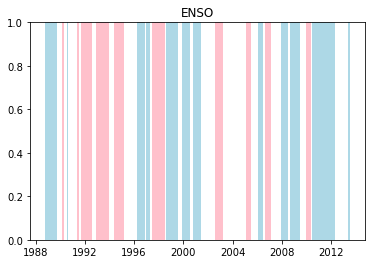

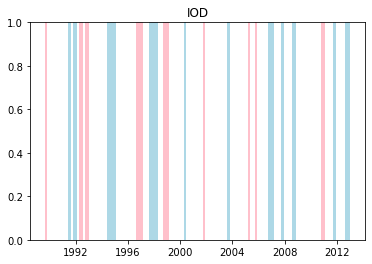

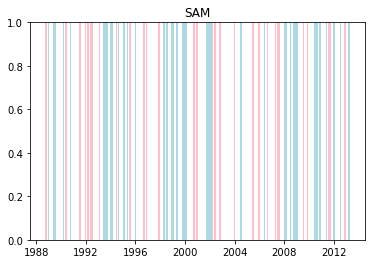

In [17]:
for driver in driver_indices:
    la_nina = phases[driver]["+ve"]
    el_nino = phases[driver]["-ve"]
    for i, group in la_nina.groupby(np.cumsum(la_nina != la_nina.shift())):
        if not group.iloc[0]:
            continue

        start = group.index[0]
        end = group.index[-1]
        plt.axvspan(start, end, facecolor="lightblue")

    for i, group in el_nino.groupby(np.cumsum(el_nino != el_nino.shift())):
        if not group.iloc[0]:
            continue

        start = group.index[0]
        end = group.index[-1]
        plt.axvspan(start, end, facecolor="pink")
    plt.title(driver.upper())
    plt.show()

## Cumulative distributions of rainfall for each phase

For the positive, negative, and neutral phase, collect all rainfall observations that occurred during that phase. We can then treat these rainfall observations as samples of a random variable, conditioned on the phase. This allows us to build the cumulative distribution function (CDF), which describes the probability distribution of the rainfall.

In [18]:
# Figure out what times the phases were active.
times = {}
for driver, ps in phases.items():
    times[driver] = {}
    for name, ph in ps.items():
        times[driver][name] = rolling_index[driver].index[ph]

In [19]:
# Estimate the mean and CDF for each phase.
means = {}
cdfs = {}
for driver, times_ in tqdm(times.items()):
    means[driver] = {}
    cdfs[driver] = {}
    for name, time in times_.items():
        means[driver][name] = np.mean(deseasonalised_rainfall.sel(time=time), axis=0)
        cdfs[driver][name] = np.sort(
            np.nan_to_num(deseasonalised_rainfall.sel(time=time)), axis=0
        )

We need to line up the CDFs despite having a different number of days. We can interpolate to do this:

In [20]:
max_rainfall = deseasonalised_rainfall.max().values
min_rainfall = 0

In [21]:
interps = {}
for driver, cdfs_ in tqdm(cdfs.items()):
    interps[driver] = {}
    for name, cdf in cdfs_.items():
        interps[driver][name] = []
        for y in range(cdf.shape[1]):
            for x in range(cdf.shape[2]):
                interps[driver][name].append(
                    # This interpolation essentially rescales each set of observations to a consistent x scale
                    # and therefore approximates the CDF. Basically converting the units from "daily" to "quantile".
                    # The 200 controls the resolution of the resulting interpolated CDF. Doesn't need to be too high.
                    np.interp(
                        np.linspace(min_rainfall, max_rainfall, 200),
                        cdf[:, y, x],
                        np.linspace(0, 1, len(cdf)),
                        left=0,
                        right=1,
                    )
                )

In [22]:
# Convert the interpolated CDFs back into numpy arrays of the appropriate shape for the next step.
for driver, interps_ in interps.items():
    for name, interp in interps_.items():
        interps[driver][name] = np.array(interp).reshape(cdf.shape[1:] + (-1,))

## Difference between active phases compared to neutral

We can characterise the influence of climate drivers over the rainfall by a) assuming that there is no confounding correlation between climate driver and rainfall, and then b) calculating the distance between the above probability distributions. There are many, many ways of comparing probability distributions. We will employ two:

1. The Kolmogorov-Smirnov (KS) distance, commonly used to determine whether two distributions are different in a test known as the "KS test". Arguably the most common statistical test, besides the Student t-test. While it is parameter-free and works on any distribution, it's also fairly weak and hence tends to under-predict differences in distributions, i.e. if it suggests that two distributions are different they probably are, but if it suggests that they are the same it might not be.
2. The sum-of-squares difference, or the Euclidean distance. This is a measure of how far apart the quantiles are, and is a good choice if you expect your quantiles to have normally-distributed noise.

In [23]:
# Kolmogorov-Smirnov.
ks = {}
for driver, cdf in interps.items():
    ks[driver] = {}
    ks[driver]["+ve"] = abs(cdf["+ve"] - cdf["neutral"]).max(axis=-1)
    ks[driver]["-ve"] = abs(cdf["-ve"] - cdf["neutral"]).max(axis=-1)

# Euclidean.
euc = {}
for driver, cdf in interps.items():
    euc[driver] = {}
    euc[driver]["+ve"] = np.sqrt(np.mean((cdf["+ve"] - cdf["neutral"]) ** 2, axis=-1))
    euc[driver]["-ve"] = np.sqrt(np.mean((cdf["-ve"] - cdf["neutral"]) ** 2, axis=-1))

Then we can plot the climate driver influence on rainfall based on KS or Euclidean distance.

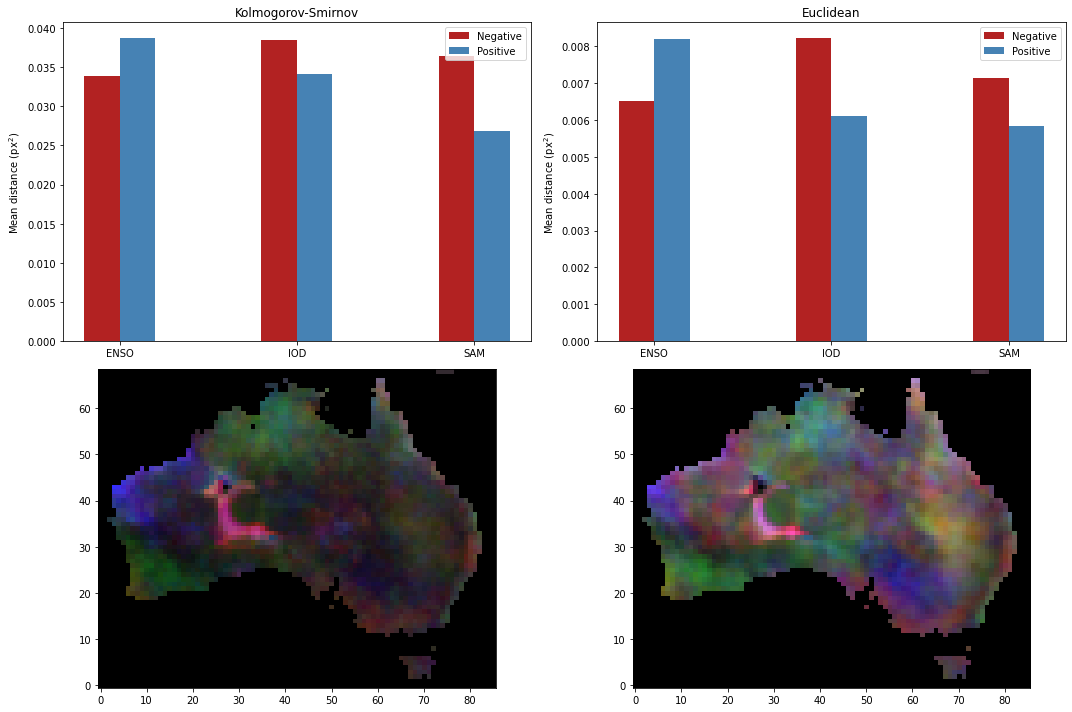

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, driver in enumerate(sorted(ks)):
    k = ks[driver]
    axs[0, 0].bar(
        [i, i + 0.2],
        [k["-ve"].mean(), k["+ve"].mean()],
        width=0.2,
        color=["firebrick", "steelblue"],
    )
axs[0, 0].legend(
    [
        matplotlib.patches.Patch(facecolor="firebrick"),
        matplotlib.patches.Patch(facecolor="steelblue"),
    ],
    ["Negative", "Positive"],
)
axs[0, 0].set_xticks(np.arange(len(ks)) + 0.1)
axs[0, 0].set_xticklabels([k.upper() for k in sorted(ks)])
axs[0, 0].set_title("Kolmogorov-Smirnov")
axs[0, 0].set_ylabel("Mean distance (px$^2$)")

for i, driver in enumerate(sorted(euc)):
    k = euc[driver]
    axs[0, 1].bar(
        [i, i + 0.2],
        [k["-ve"].mean(), k["+ve"].mean()],
        width=0.2,
        color=["firebrick", "steelblue"],
    )
axs[0, 1].legend(
    [
        matplotlib.patches.Patch(facecolor="firebrick"),
        matplotlib.patches.Patch(facecolor="steelblue"),
    ],
    ["Negative", "Positive"],
)
axs[0, 1].set_xticks(np.arange(len(ks)) + 0.1)
axs[0, 1].set_xticklabels([k.upper() for k in sorted(ks)])
axs[0, 1].set_title("Euclidean")
axs[0, 1].set_ylabel("Mean distance (px$^2$)")

totals = {}
for driver, k in ks.items():
    totals[driver] = np.hypot(k["+ve"], k["-ve"])

lon, lat = np.meshgrid(rainfall.longitude.values, rainfall.latitude.values)
colours = np.ma.stack(
    [
        mpl_toolkits.basemap.maskoceans(lon, lat, totals["enso"]),
        mpl_toolkits.basemap.maskoceans(lon, lat, totals["sam"]),
        mpl_toolkits.basemap.maskoceans(lon, lat, totals["iod"]),
    ]
).transpose(1, 2, 0)
max_colour = colours.max()
axs[1, 0].imshow(np.where(colours.mask, np.nan, colours / max_colour), origin="lower")

totals = {}
for driver, k in euc.items():
    totals[driver] = np.hypot(k["+ve"], k["-ve"])

colours = np.ma.stack(
    [
        mpl_toolkits.basemap.maskoceans(lon, lat, totals["enso"]),
        mpl_toolkits.basemap.maskoceans(lon, lat, totals["sam"]),
        mpl_toolkits.basemap.maskoceans(lon, lat, totals["iod"]),
    ]
).transpose(1, 2, 0)
max_colour = colours.max()
axs[1, 1].imshow(np.where(colours.mask, np.nan, colours / max_colour), origin="lower")

plt.tight_layout()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html).